In [1]:
import string
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from numpy.fft import fft2, ifft2

In [2]:
def draw_multiline_text(text, size=(800, 600), font='arial', show=False, font_size=-1):

    def fits():
        return (upper_x > offset_x and lower_x < size[0] - offset_x
                and upper_y > offset_y and lower_y < size[1] - offset_y)

    offset_x = size[0] // 5
    offset_y = size[1] // 5
    center = (size[0] // 2, size[1] // 2)
    img = Image.new("RGB", size, (255, 255, 255))
    d = ImageDraw.Draw(img)
    if font_size != -1:
        fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
        upper_x, upper_y, lower_x, lower_y = d.multiline_textbbox(center, text, anchor='mm', font=fnt)
        if not fits():
            font_size = -1

    if font_size == -1:
        l = 5
        r = 100
        while l <= r:
            s = (l + r) // 2
            fnt = ImageFont.truetype(f"fonts/{font}.ttf", s)
            upper_x, upper_y, lower_x, lower_y = d.multiline_textbbox(center, text, anchor='mm', font=fnt)
            if fits():
                l = s + 1
            else:
                r = s - 1
        font_size = r

    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    d.multiline_text(center, text, anchor='mm', font=fnt, fill=(0, 0, 0))
    if show:
        display(img)
    return img, font_size

In [3]:
def remove_black_padding(img):
    matrix = np.array(img)
    matrix[:, :np.argmax(matrix[0])] = 255
    return Image.fromarray(matrix)

def draw_single_character(char, font_size, font='arial', show=False):
    img = Image.new("L", (200, 200), 255)
    d = ImageDraw.Draw(img)
    fnt = ImageFont.truetype(f"fonts/{font}.ttf", font_size)
    w = d.textbbox((0, 0), char, font=fnt)
    d.text((0, 0), char, font=fnt, fill=0)
    img = img.crop(w)
    if char == 'j':
        img = remove_black_padding(img)
    if show:
        display(img)
    return img

In [4]:
def rotate_image(img, angle):
    return img.rotate(angle, fillcolor=(255, 255, 255), resample=Image.BICUBIC)

In [5]:
char_a = draw_single_character('j', 99, font='open-sans')
display(char_a)

In [6]:
characters = string.ascii_lowercase + ".,!?"
# txt = list(characters)
# txt = "".join([4*x for x in txt])
# txt = txt[::4] + '\n'+ txt[1::4] +'\n'+ txt[2::4] + '\n'+ txt[3::4]

In [39]:

txt = '''
nature s first green is gold
her hardest hue to hold.
her early leaf s a flower
but only so an hour.

'''

out, f_size = draw_multiline_text(txt, font='arial')

In [40]:
def get_all_character(font, fontsize):
    return list(map(lambda x: draw_single_character(x, fontsize, font), characters))


In [41]:
def img_to_matrix(img):
    img = img.convert('L')
    return np.array(img)

def matrix_to_image(matrix):
    return Image.fromarray(matrix)

def invert_colors(matrix):
    return 255 - matrix

def convolve_images(pattern, image):
    s = (max(pattern.shape[0], image.shape[0]), max(pattern.shape[1], image.shape[1]))
    return np.abs(ifft2(fft2(pattern[::-1, ::-1], s=s) * fft2(image, s=s)))

def normalize(matrix):
    return 255 * (matrix / np.max(matrix))

def threshold_matrix(matrix, k=150):
    black = matrix < k
    white = matrix >= k
    matrix[black] = 0
    matrix[white] = 255
    return matrix


In [42]:
def reduce_noise(img, k = 80):
    matrix = img_to_matrix(img)
    U, S, V = np.linalg.svd(matrix)
    mat = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
    return matrix_to_image(normalize(mat)).convert('L')


In [43]:
def count_lines(img):
    matrix = invert_colors(threshold_matrix(img_to_matrix(img)))
    matrix = np.sum(matrix, axis=1)
    return matrix.shape[0] - np.count_nonzero(matrix)

def count_something(img):
    matrix = invert_colors(threshold_matrix(img_to_matrix(img)))
    rows = np.argmax(matrix[:, ::-1], axis=1)
    cols = np.argmax(matrix[::-1, :], axis=0)
    return 3*np.sum(rows) + np.sum(cols)

def upside_down(img):
    return count_something(img) < count_something(rotate_image(img, 180))

def correct_angle(img):
    best_angle = 0
    best_score = 0
    for i in range(180):
        rotated = rotate_image(img, i)
        if (score := count_lines(rotated)) > best_score:
            best_score = score
            best_angle = i

    img = rotate_image(img, best_angle)
    if upside_down(img):
        return rotate_image(img, 180)
    return img


In [44]:
from bisect import bisect_left
from intervaltree import IntervalTree, Interval

def split_lines(points, height):
    points.sort()
    lines = [points[0][0] - 1]
    height /= 3
    last_x = points[0][0]
    for x, y in points[1:]:
        if x - last_x > height:
            lines.append(x - 1)
        last_x = x
    return lines


def find_occurrences(pattern, image, eps=0.05):
    convolution = convolve_images(pattern, image)
    pattern = np.array(pattern, dtype=float)
    max_correlation = np.sum(pattern * pattern)
    return list(zip(*np.where(np.abs(convolution - max_correlation) < eps * max_correlation)))


def create_graph(font, font_size, chars):
    images = [draw_multiline_text(c, size=(200, 200), font=font, font_size=font_size)[0] for c in characters]
    images = list(map(img_to_matrix, images))
    images = list(map(invert_colors, images))

    g = [[] for _ in range(len(chars))]
    for i, pattern in enumerate(chars):
        for j, image in enumerate(images):
            if i != j and find_occurrences(pattern, image):
                g[j].append(i)
    return g


def dfs(v, g, visit, order):
    visit[v] = True
    for s in g[v]:
        if not visit[s]:
            dfs(s, g, visit, order)
    order.append(v)

def topological_sort(g):
    n = len(g)
    visit = np.full(n, False)
    order = []
    for i in range(n):
        if not visit[i]:
            dfs(i, g, visit, order)
    return np.array(order)[::-1]



def ocr(image, font, font_size, order=None):
    # image = correct_angle(image)
    chars = get_all_character(font, font_size)
    char_arrays = list(map(img_to_matrix, chars))
    char_arrays = list(map(invert_colors, char_arrays))
    if order is None:
        g = create_graph(font, font_size, char_arrays)
        order = topological_sort(g)

    matrix = img_to_matrix(image)
    matrix = invert_colors(matrix)

    lines = split_lines([point for char in char_arrays for point in find_occurrences(char, matrix)]
                        , max(char.shape[1] for char in char_arrays))

    n = len(lines)
    intervals = [IntervalTree() for _ in range(n)]
    interval_letter_map = [{} for _ in range(n)]

    for char_ind in order:
        char_occur = find_occurrences(char_arrays[char_ind], matrix)
        yes_occur = []
        for x, y in char_occur:
            interval = bisect_left(lines, x) - 1
            left, right = y - char_arrays[char_ind].shape[1] + 2, y - 2
            if not intervals[interval].overlaps(Interval(left, right)):
                intervals[interval].add(Interval(left, right))
                interval_letter_map[interval][(left, right)] = char_ind
                yes_occur.append((x, y))

        # new_img = Image.fromarray(matrix).convert('RGB')
        # new_array = np.array(new_img)
        # a, b = char_arrays[char_ind].shape
        # red = (255, 0, 0)
        # for i, j in yes_occur:
        #     new_array[i:i-a:-1, j] = red
        #     new_array[i:i-a:-1, j - b] = red
        #     new_array[i, j:j-b:-1] = red
        #     new_array[i - a, j:j-b:-1] = red
        #
        # display(Image.fromarray(new_array))

    space_width = img_to_matrix(draw_single_character(' ', font_size, font)).shape[1]
    sorted_lines = [sorted(list(line.items())) for line in interval_letter_map]
    leftmost = min([sorted_lines[i][0][0][0] for i in range(n)])
    output = ""

    for line in sorted_lines:
        last_end = leftmost
        for (x, y), char in line:
            if x - last_end > space_width:
                output += " "*((x - last_end) // space_width)
            output += characters[char]
            last_end = y
        output += '\n'

    return output

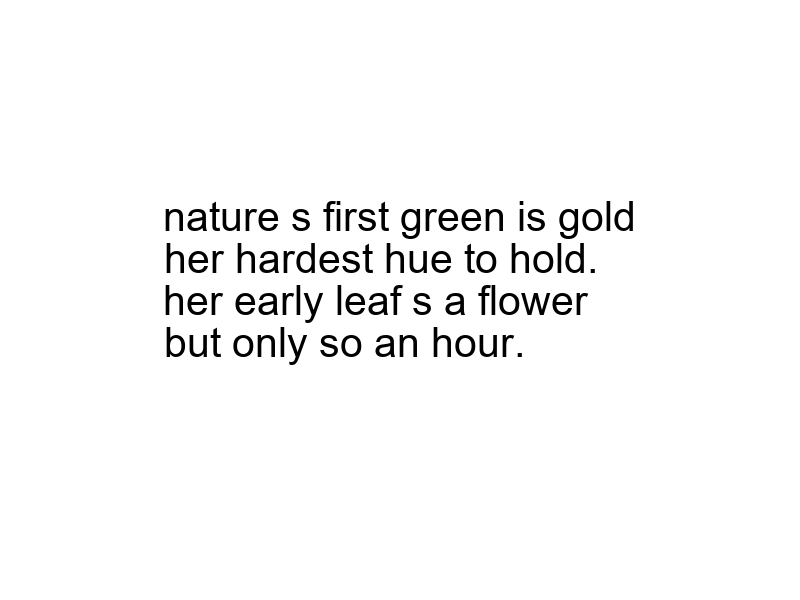

In [45]:
# out = rotate_image(out, 20)
display(out)

In [49]:
points_s = ocr(out, 'arial', f_size)

In [50]:
print(txt)


nature s first green is gold
her hardest hue to hold.
her early leaf s a flower
but only so an hour.




In [51]:
print(points_s)

nature s first green is gold
her hardest hue to hold.
her early leaf s a flower
but only so an hour.



In [364]:
print(f_size)

45
